# Modeling 2 - MultiLabel (add 2 Traits: Tancho and GinRin)

In [78]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import json
import os
import math

from sklearn.metrics import multilabel_confusion_matrix, classification_report, \
  precision_score, recall_score, f1_score

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights

In [3]:
# set device

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [4]:
# import dataset from json

with open('data/df_5labels.json', 'r') as f:
  data = json.load(f)

df = pd.DataFrame(data)
df

,image_path,tags,uuid,length,price_length,cleaned_price,multi_label,not_empty
0,grandkoi_data/12a49e_High Quality Gin Rin Show...,"[Gin, Rin, Showa]",12a49e,32.0,10,34999.0,"[Gin, Rin, Showa]",True
1,grandkoi_data/9ac3a8_High Quality Gin Rin show...,"[Gin, Rin, showa]",9ac3a8,32.0,10,34999.0,"[Gin, Rin, showa]",True
2,grandkoi_data/66c804_Gin Rin Karashigoi.jpeg,"[Gin, Rin, Karashigoi]",66c804,28.0,9,6999.0,"[Gin, Rin]",True
3,grandkoi_data/34353c_Gin Rin Benigoi.jpeg,"[Gin, Rin, Benigoi]",34353c,25.0,9,4999.0,"[Gin, Rin]",True
4,grandkoi_data/b1c670_Tancho Sanke.jpeg,"[Tancho, Sanke]",b1c670,22.0,9,3499.0,"[Tancho, Sanke]",True
...,...,...,...,...,...,...,...,...
854,sacramentokoi_data/83d8dc_Tancho_Ochiba_14″_–_...,"[Tancho, Ochiba]",83d8dc,14.0,7,375.0,[Tancho],True
855,sacramentokoi_data/0e4681_Tancho_Sakura_Ogon_2...,"[Tancho, Sakura, Ogon]",0e4681,20.0,7,950.0,[Tancho],True
856,sacramentokoi_data/84af0c_Tancho_Sakura_Ogon_2...,"[Tancho, Sakura, Ogon]",84af0c,22.0,9,2100.0,[Tancho],True
857,sacramentokoi_data/10e266_Tancho_Showa_15″_–_2...,"[Tancho, Showa]",10e266,15.0,7,375.0,"[Tancho, Showa]",True


# Multi-Hot Encode Labels

In [58]:
# multi-hot encode the labels

class_labels = ['kohaku', 'sanke', 'showa', 'tancho', 'gin']
mhot_encoded = []

for label in class_labels:
  mhot_encoded.append(1 if label in [x.lower() for x in df.iloc[0]['multi_label']] else 0)

mhot_encoded

[0, 0, 1, 0, 1]

In [6]:
# create a function to multi-hot encode the labels

def mhot_encoder(row: list) -> list:
  """Multi-hot encode labels into a binary array.

  Loops over a list of labels to check if it is in the given row.
  Appending 1 if true and 0 if false.

  Args:
    row(list): A row of a DataFrame

  Returns:
    list: A list of binary encoded labels
  """

  labels = ['kohaku', 'sanke', 'showa', 'tancho', 'gin']
  mhot_encoded = []

  for label in labels:
    mhot_encoded.append(1 if label in [x.lower() for x in row['multi_label']] else 0)

  return mhot_encoded

In [7]:
# apply the function to the dataframe

df['mhe'] = df.apply(mhot_encoder, axis=1)
df

,image_path,tags,uuid,length,price_length,cleaned_price,multi_label,not_empty,mhe
0,grandkoi_data/12a49e_High Quality Gin Rin Show...,"[Gin, Rin, Showa]",12a49e,32.0,10,34999.0,"[Gin, Rin, Showa]",True,"[0, 0, 1, 0, 1]"
1,grandkoi_data/9ac3a8_High Quality Gin Rin show...,"[Gin, Rin, showa]",9ac3a8,32.0,10,34999.0,"[Gin, Rin, showa]",True,"[0, 0, 1, 0, 1]"
2,grandkoi_data/66c804_Gin Rin Karashigoi.jpeg,"[Gin, Rin, Karashigoi]",66c804,28.0,9,6999.0,"[Gin, Rin]",True,"[0, 0, 0, 0, 1]"
3,grandkoi_data/34353c_Gin Rin Benigoi.jpeg,"[Gin, Rin, Benigoi]",34353c,25.0,9,4999.0,"[Gin, Rin]",True,"[0, 0, 0, 0, 1]"
4,grandkoi_data/b1c670_Tancho Sanke.jpeg,"[Tancho, Sanke]",b1c670,22.0,9,3499.0,"[Tancho, Sanke]",True,"[0, 1, 0, 1, 0]"
...,...,...,...,...,...,...,...,...,...
854,sacramentokoi_data/83d8dc_Tancho_Ochiba_14″_–_...,"[Tancho, Ochiba]",83d8dc,14.0,7,375.0,[Tancho],True,"[0, 0, 0, 1, 0]"
855,sacramentokoi_data/0e4681_Tancho_Sakura_Ogon_2...,"[Tancho, Sakura, Ogon]",0e4681,20.0,7,950.0,[Tancho],True,"[0, 0, 0, 1, 0]"
856,sacramentokoi_data/84af0c_Tancho_Sakura_Ogon_2...,"[Tancho, Sakura, Ogon]",84af0c,22.0,9,2100.0,[Tancho],True,"[0, 0, 0, 1, 0]"
857,sacramentokoi_data/10e266_Tancho_Showa_15″_–_2...,"[Tancho, Showa]",10e266,15.0,7,375.0,"[Tancho, Showa]",True,"[0, 0, 1, 1, 0]"


# Train/Test/Val Split Using MultilabelStratifiedShuffleSplit

In [30]:
# prepare for stratified split using msss

X = np.array(df['image_path'].tolist())
y = np.array(df['mhe'].tolist())

X.shape, y.shape

((859,), (859, 5))

In [25]:
# define stratified splitter for train and testval split

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

In [27]:
# apply stratified split to X and y

for train_index, testval_index in msss.split(X, y):
  print("TRAIN:", train_index, "TESTVAL:", testval_index)
  X_train, X_testval = X[train_index], X[testval_index]
  y_train, y_testval = y[train_index], y[testval_index]

TRAIN: [  1   2   3   4   5   6   7  10  11  12  15  17  18  20  21  22  23  24
  25  27  28  29  30  31  32  33  38  39  41  42  43  44  45  48  49  50
  51  53  54  55  56  57  58  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  76  77  78  79  81  82  83  84  86  90  92  94  96  97  99
 100 101 102 104 107 108 109 110 111 113 114 115 118 119 120 121 122 123
 124 125 127 130 131 132 133 134 135 136 137 138 139 140 141 143 145 147
 148 149 153 154 155 156 158 159 161 162 163 164 165 168 170 172 173 174
 175 176 178 181 182 184 185 188 190 191 192 193 195 196 198 199 201 204
 205 208 209 210 211 212 213 214 215 216 218 220 221 222 223 225 226 227
 228 229 231 232 234 235 239 241 244 246 247 250 251 253 254 255 256 259
 260 261 263 264 265 266 267 269 270 272 273 274 275 278 280 281 282 284
 285 286 288 289 290 291 292 294 296 297 298 299 300 302 303 304 306 307
 309 311 313 314 316 319 321 323 324 325 326 327 328 329 331 332 333 334
 335 336 338 339 340 341 342 343 344 346 350

In [29]:
# define stratified splitter for test/val

msss2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

# apply stratified split to X and y

for test_index, val_index in msss2.split(X_testval, y_testval):
  print("TEST:", test_index, "VAL:", val_index)
  X_test, X_val = X[test_index], X[val_index]
  y_test, y_val = y[test_index], y[val_index]

TEST: [  4   8   9  10  11  12  15  16  19  22  23  24  28  29  30  31  32  33
  34  36  38  39  40  41  43  45  48  52  54  56  58  59  60  62  66  68
  73  74  75  76  79  80  82  84  85  86  89  90  92  95  96  97  98 102
 103 104 105 106 108 110 111 113 115 116 122 123 124 126 127 129 131 132
 138 139 144 145 148 149 156 157 158 160 162 165 169 170 173 175 176 178
 179 186 189 194 196 197 198 199 200 201 202 203 204 205 207 210 211 212
 216 217 219 220 221 225 226 227 230 232 233 234 235 236 237 238 241 245
 248 252 253 255 256 257] VAL: [  0   1   2   3   5   6   7  13  14  17  18  20  21  25  26  27  35  37
  42  44  46  47  49  50  51  53  55  57  61  63  64  65  67  69  70  71
  72  77  78  81  83  87  88  91  93  94  99 100 101 107 109 112 114 117
 118 119 120 121 125 128 130 133 134 135 136 137 140 141 142 143 146 147
 150 151 152 153 154 155 159 161 163 164 166 167 168 171 172 174 177 180
 181 182 183 184 185 187 188 190 191 192 193 195 206 208 209 213 214 215
 218 222 223 2

In [32]:
# check the shapes

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((601,), (601, 5), (132,), (132, 5), (126,), (126, 5))

In [38]:
# recombine the X and y for loading into tensors

train_df = pd.DataFrame({'image_path': X_train, 'mhe': list(y_train)})
test_df = pd.DataFrame({'image_path': X_test, 'mhe': list(y_test)})
val_df = pd.DataFrame({'image_path': X_val, 'mhe': list(y_val)})

# check the shape of the dataframes

train_df.shape, test_df.shape, val_df.shape

((601, 2), (132, 2), (126, 2))

In [46]:
train_df

,image_path,mhe
0,grandkoi_data/9ac3a8_High Quality Gin Rin show...,"[0, 0, 1, 0, 1]"
1,grandkoi_data/66c804_Gin Rin Karashigoi.jpeg,"[0, 0, 0, 0, 1]"
2,grandkoi_data/34353c_Gin Rin Benigoi.jpeg,"[0, 0, 0, 0, 1]"
3,grandkoi_data/b1c670_Tancho Sanke.jpeg,"[0, 1, 0, 1, 0]"
4,grandkoi_data/58e2f4_Tancho Sanke.jpeg,"[0, 1, 0, 1, 0]"
...,...,...
596,sacramentokoi_data/a392f8_Tancho_Kujaku_21″_–_...,"[0, 0, 0, 1, 0]"
597,sacramentokoi_data/83d8dc_Tancho_Ochiba_14″_–_...,"[0, 0, 0, 1, 0]"
598,sacramentokoi_data/0e4681_Tancho_Sakura_Ogon_2...,"[0, 0, 0, 1, 0]"
599,sacramentokoi_data/10e266_Tancho_Showa_15″_–_2...,"[0, 0, 1, 1, 0]"


# Creating Datasets

In [43]:
# create a custom multi-label image dataset class

class CustomMultiLabelDataset(Dataset):
  def __init__(self, image_paths, labels, transforms=None):
    self.image_paths = image_paths
    self.labels = labels
    self.transforms = transforms

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    # load and transform image
    image = Image.open(self.image_paths[idx]).convert('RGB')
    if self.transforms:
      image = self.transforms(image)

    # convert label to tensor
    label = torch.FloatTensor(self.labels[idx])

    return image, label

In [51]:
# define the transformer

transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
])

# set the file directory path

dir_path = '../pictures/'

In [52]:
# create a helper function to add the directory path to file path

def prepend_dir(df, dir_path):
    return df['image_path'].apply(lambda x: os.path.join(dir_path, x)).tolist()

# create the datasets

train_ds = CustomMultiLabelDataset(
    image_paths=prepend_dir(train_df, dir_path),
    labels=train_df['mhe'].tolist(),
    transforms=transform
)

val_ds = CustomMultiLabelDataset(
    image_paths=prepend_dir(val_df, dir_path),
    labels=val_df['mhe'].tolist(),
    transforms=transform
)

test_ds = CustomMultiLabelDataset(
    image_paths=prepend_dir(test_df, dir_path),
    labels=test_df['mhe'].tolist(),
    transforms=transform
)

In [49]:
# create data loaders

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [53]:
# check the tensors

for images, labels in train_loader:
    print(type(images), images.shape)
    print(type(labels), labels.shape)
    break

for images, labels in test_loader:
    print(type(images), images.shape)
    print(type(labels), labels.shape)
    break

for images, labels in val_loader:
    print(type(images), images.shape)
    print(type(labels), labels.shape)
    break

<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])


# Baseline Model Using ResNet18 (unfrozen layers)

In [61]:
# define the model

num_classes = len(class_labels)

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# define loss and optimizer

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
# create the training loop

num_epochs = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
  # set the model to training mode
  model.train()
  # initialize loss tracking
  total_train_loss = 0
  train_correct = 0
  train_total = 0

  # loop through training data in batches
  for images, labels in train_loader:
    images = images.to(device) # move data to MPS
    labels = labels.to(device) # move data to MPS

    # reset the gradients
    optimizer.zero_grad()
    # forward pass
    outputs = model(images)
    # compute the loss
    loss = criterion(outputs, labels)
    # backward pass
    loss.backward()
    # update model weights
    optimizer.step()

    # add batch loss to total
    total_train_loss += loss.item()

    # apply sigmoid and threshold to get multi-label predictions
    probs = torch.sigmoid(outputs)
    predicted = (probs > 0.5).float()

    # count the correct predictions per label
    train_correct += (predicted == labels).float().sum().item()
    train_total += labels.numel()

  avg_train_loss = total_train_loss / len(train_loader)
  train_acc = train_correct / train_total

  train_losses.append(avg_train_loss)
  train_accuracies.append(train_acc)

  # VALIDATION
  model.eval()
  total_val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for images, labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      total_val_loss += loss.item()

      # apply sigmoid and threshold to get multi-label predictions
      probs = torch.sigmoid(outputs)
      predicted = (probs > 0.5).float()

      # count the correct predictions per label
      val_correct += (predicted == labels).float().sum().item()
      val_total += labels.numel()

  avg_val_loss = total_val_loss / len(val_loader)
  val_acc = val_correct / val_total

  val_losses.append(avg_val_loss)
  val_accuracies.append(val_acc)

  # print loss for this epochs
  print(f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2%} | "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2%}")

Epoch 1/20 | Train Loss: 0.2768, Train Acc: 88.55% | Val Loss: 0.2250, Val Acc: 92.38%
Epoch 2/20 | Train Loss: 0.1599, Train Acc: 93.61% | Val Loss: 0.6227, Val Acc: 84.60%
Epoch 3/20 | Train Loss: 0.1173, Train Acc: 95.57% | Val Loss: 0.1374, Val Acc: 93.97%
Epoch 4/20 | Train Loss: 0.0805, Train Acc: 97.04% | Val Loss: 0.0989, Val Acc: 96.03%
Epoch 5/20 | Train Loss: 0.0540, Train Acc: 98.27% | Val Loss: 0.2995, Val Acc: 86.98%
Epoch 6/20 | Train Loss: 0.0497, Train Acc: 98.44% | Val Loss: 0.3659, Val Acc: 89.37%
Epoch 7/20 | Train Loss: 0.0487, Train Acc: 98.07% | Val Loss: 0.2351, Val Acc: 91.27%
Epoch 8/20 | Train Loss: 0.0413, Train Acc: 98.34% | Val Loss: 0.4733, Val Acc: 87.46%
Epoch 9/20 | Train Loss: 0.0568, Train Acc: 98.04% | Val Loss: 0.1686, Val Acc: 94.29%
Epoch 10/20 | Train Loss: 0.0293, Train Acc: 99.03% | Val Loss: 0.1076, Val Acc: 96.83%
Epoch 11/20 | Train Loss: 0.0304, Train Acc: 98.90% | Val Loss: 0.0726, Val Acc: 98.10%
Epoch 12/20 | Train Loss: 0.0306, Train A

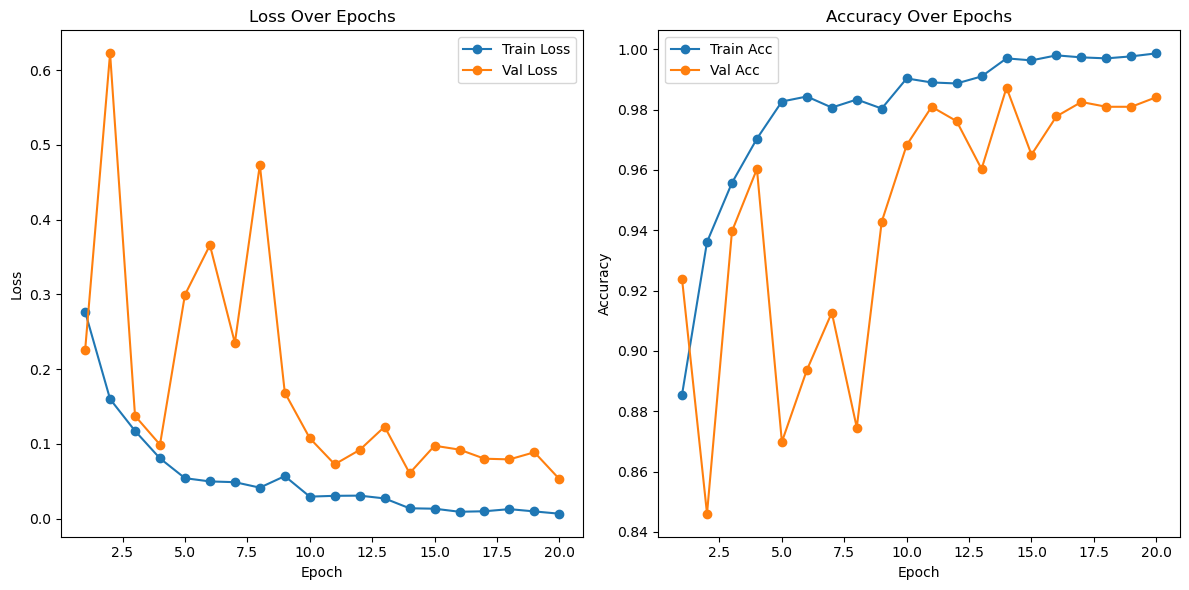

In [64]:
# plot the loss and accuracy over epochs

epochs = range(1, num_epochs +1)
plt.figure(figsize=(12,6))

# plot the loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker ='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot the accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Acc', marker='o')
plt.plot(epochs, val_accuracies, label='Val Acc', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [83]:
# calculate the validation metrics

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()

        all_preds.append(preds.cpu())   # moves predictions and labels from GPU to CPU
        all_labels.append(labels.cpu().int()) # convert labels to int (for metrics like precision/recall)

# Stack all batches together (concatenate all mini-batch tensors into one big tensor)
all_preds = torch.cat(all_preds).numpy()    # convert to numpy for metrics
all_labels = torch.cat(all_labels).numpy()

# Calculate accuracy (all labels must be correct)
all_preds_tensor = torch.tensor(all_preds)
all_labels_tensor = torch.tensor(all_labels)
matches = (all_preds_tensor == all_labels_tensor).all(dim=1).float() # checks if all labels match
accuracy = matches.mean().item()    # compute overall accuracy

# Metrics
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

print(f"Validation Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Validation Accuracy: 0.9365, F1 Score: 0.9755, Precision: 0.9774, Recall: 0.9750


In [74]:
# check the classification report

print(classification_report(all_labels, all_preds, target_names=class_labels))

# create the confusion matrix

conf_matrices = multilabel_confusion_matrix(all_labels, all_preds)

              precision    recall  f1-score   support

      kohaku       0.97      1.00      0.99        35
       sanke       0.93      1.00      0.97        14
       showa       1.00      0.98      0.99        43
      tancho       1.00      1.00      1.00        13
         gin       0.98      0.90      0.94        59

   micro avg       0.98      0.96      0.97       164
   macro avg       0.98      0.98      0.98       164
weighted avg       0.98      0.96      0.97       164
 samples avg       0.98      0.97      0.97       164



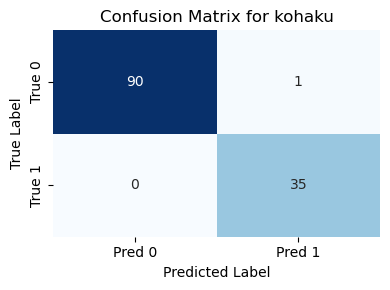

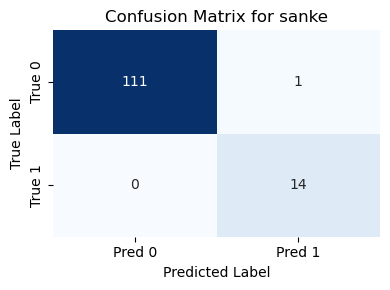

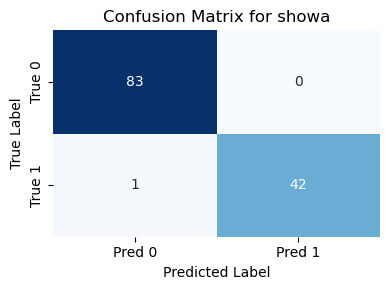

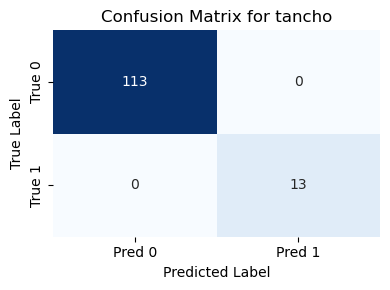

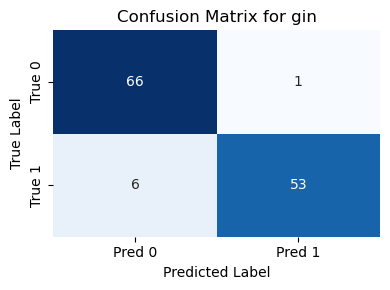

In [76]:
# display the confusion matrix for each label

for i, cm in enumerate(conf_matrices):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix for {class_labels[i]}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

- Most of the errors are due to False Negatives of GinRin, where the model is predicting that the image is not GinRin, but in fact, it does.
- The recall for ginrin is 0.90.

# Balance Classes

In [100]:
# use BCEWithLogitsLoss's pos_weights to balance class weights

# step 1: calculate the weights
label_counts = y_train.sum(axis=0)
print(f'label_counts: {label_counts}')

total_samples = y_train.shape[0]
print(f'total_samples: {total_samples}')

pos_weights = total_samples / label_counts
print(f'pos_weights: {pos_weights}')


label_counts: [181 165 126  42 191]
total_samples: 601
pos_weights: [ 3.32044199  3.64242424  4.76984127 14.30952381  3.14659686]


In [ ]:
# create a function for the training loop
